In [1]:
import sys
sys.path.insert(0, "/home/katharina/vame_approach/VAME")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from vame.analysis.kinutils import KinVideo, create_grid_video
import os
from datetime import datetime
from vame.util.auxiliary import read_config
import logging
import re
from pathlib import Path
from IPython import display
from sklearn.manifold import TSNE
import umap
from fcmeans import FCM
from ipywidgets import Output, GridspecLayout
from scipy.spatial.distance import pdist, squareform
from vame.analysis.visualize import create_aligned_mouse_video, create_pose_snipplet, create_visual_comparison,thin_dataset_iteratively, find_percentile_threshold
from matplotlib import cm
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')


%reload_ext autoreload
%autoreload 2

Using CUDA
GPU active: True
GPU used: GeForce RTX 3090


## 1 ) Load latent vectors

In [2]:
PROJECT_PATH = "/home/katharina/vame_approach/themis_tail_belly_align"

# select a time point to find similar neighbors to
anchor_idx = int(335.6* 120) # standing mouse
#anchor_idx = int(373.32 * 120) # walking mouse+ tick at the end

SHOW_ALIGNED = True # if True create an aligned video to create snipplets from; otherwise use original video
min_dist_nn_factor = 1 # config["time_window"] * min_dist_nn_factor will define the min distance in time points between the anchor and between sampled neighbors

trained_models = [
    (datetime.strptime(element, "%m-%d-%Y-%H-%M"), element)
    for element in os.listdir(os.path.join(PROJECT_PATH, "model"))
]
# sort by time step
trained_models.sort(key=lambda x: x[0])
latest_model = trained_models[-1][-1]

config_file = os.path.join(PROJECT_PATH, "model", latest_model, "config.yaml")
config = read_config(config_file)
# select landmark file
landmark_file = config["video_sets"][0]
data_path = os.path.join(
        PROJECT_PATH,
        "results",
        latest_model,
        landmark_file,
        config["model_name"],
        "kmeans-" + str(config["n_init_kmeans"]),
    )
latent_vectors_all = np.load(
        os.path.join(data_path, "latent_vector_" + landmark_file + ".npy")
    )

## 2) Sample anchor latent embedding and visualize together with its nearest neighbors vs distant samples

Exploring the latent space visually by sampling an anchor embedding together with vectors that are close to the anchor in the embedding space and visualizing their corresponding time series. To compare the quality of the learned latent space also timeseries corresponding with latent vectors that are far away from the anchor in the latent space are shown.

In [3]:
# remove latent embeddings that correspond to time series that heavily overlap with the time series of the anchor embedding, to find 
# similar samples to the anchor that are temporally further appart
window_start = max(0, anchor_idx - int(config["time_window"] * min_dist_nn_factor))
window_end = min(len(latent_vectors_all), anchor_idx + int(config["time_window"] * min_dist_nn_factor))
selected_latent_vector = latent_vectors_all[anchor_idx, :]

dist_orig = np.sqrt(np.sum((latent_vectors_all - selected_latent_vector.reshape(1,-1))**2, axis=1))

time_points = np.arange(0, latent_vectors_all.shape[0])
time_points = np.concatenate([time_points[0:window_start], time_points[window_end:-1]])
latent_vectors = np.concatenate([latent_vectors_all[0:window_start], latent_vectors_all[window_end:-1]])
# distances between each latent vector and the selected one excluding the distances of latent vectors corresponding to temporally close frames
dist = np.concatenate([dist_orig[0:window_start], dist_orig[window_end:-1]])

# select 8 neighbors, and enshure the neighbors are also separated by a min timespan from each other
selected_neighbor_idx = []
while len(selected_neighbor_idx) < 8 and len(dist) > 0:
    n_idx = np.argmin(dist)
    selected_neighbor_idx.append(time_points[n_idx])
    # remove all distances close to the selected anchor
    is_far_away = np.abs(time_points - time_points[n_idx]) > int(config["time_window"] * min_dist_nn_factor)
    dist = dist[is_far_away]
    time_points = time_points[is_far_away]

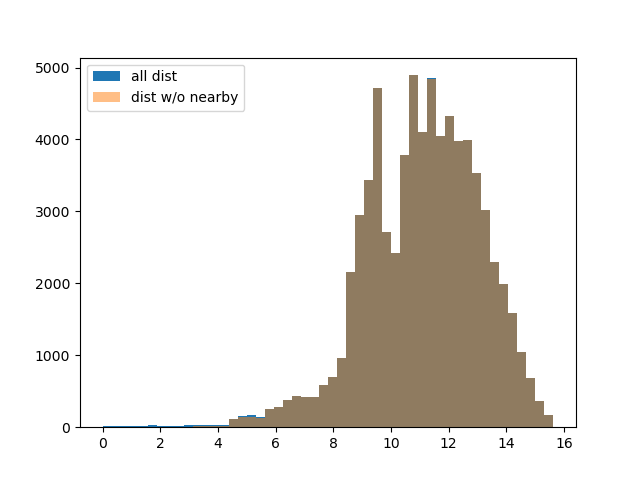

In [4]:
# Plot histogramm of distances
%matplotlib widget
# plot dist showing the neighbors but not the excluded ones?
# plotting dist removing only the nearby neighbors
bins = 50
hist_range = (min(dist_orig), max(dist_orig))
dist_wo_nearby = np.concatenate([dist_orig[0:window_start], dist_orig[window_end:-1]])
plt.hist(dist_orig,bins=bins, range=hist_range, label="all dist")
plt.hist(dist_wo_nearby, bins=bins, range=hist_range, alpha=0.5, label="dist w/o nearby")
plt.legend()

Observation: the latent vectors corresponding to time series that are heavily overlapping with the time series corresponding to the anchor embedding are also very close in the latent space. Therefore in a later stage some data dilution is needed to reduce the latent vectors that essentially represent almost the same time series. However, just subsampling the latent vectors such that they would correspond with subsampling the corresponding time series in a fixed grid can potentially destroy the phase information.

### 2.1) Visualize anchor vs nearest neighbors

In [5]:
# get corresponding video
video_df = pd.read_csv(os.path.join(PROJECT_PATH, "video_info.csv"))
video_id = int(re.findall(r"\d+", landmark_file)[0])
video_file = os.path.join(
            *video_df[video_df["video_id"] == video_id][
                ["vid_folder", "vid_file"]
            ].values[0]
        )
subject, date, camera_pos, video_name = Path(video_file).parts[-4:]


In [6]:
# all selected time points including anchor and its nearest neighbors
time_ids = [anchor_idx, *selected_neighbor_idx]
# change from frames to seconds by dividing with fps
if SHOW_ALIGNED:
    video_name, ending = os.path.basename(video_file).split(".")
    aligned_video_path = os.path.join(
        PROJECT_PATH,
        "results", "align", "a" + video_name + "." + ending)
    if not os.path.exists(aligned_video_path):
        landmark_file_path = os.path.join(PROJECT_PATH, "landmarks", landmark_file+".csv")
        create_aligned_mouse_video(
            video_file,
            landmark_file,
            os.path.dirname(aligned_video_path),
            crop_size=(300, 300))

    selected_video_file = aligned_video_path
else:
    selected_video_file = video_file
#print(selected_video_file)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()


video_clip_data = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in time_ids]
#print(video_clip_data)
grid_video_name = create_grid_video(video_clip_data,video_clip_duration,speed=0.5) # duration is in seconds!!
dist_matrix = np.round(squareform(pdist(latent_vectors_all[time_ids])), 3)
print(f"Distances between latent embeddings:\n {dist_matrix}")
display.Video(grid_video_name, embed=True,html_attributes="loop autoplay", width=600,height=600)


INFO: 2022-05-26 13:41:26,828: Scene 0 done (100%).
INFO: 2022-05-26 13:41:26,828: Concatenating 1 scenes.


Distances between latent embeddings:
 [[0.    3.209 4.536 4.616 4.824 5.454 5.549 5.592 5.622]
 [3.209 0.    4.101 2.696 4.42  4.189 5.644 5.372 6.307]
 [4.536 4.101 0.    4.528 3.923 4.11  4.593 4.887 5.685]
 [4.616 2.696 4.528 0.    4.157 3.877 5.214 4.854 6.426]
 [4.824 4.42  3.923 4.157 0.    2.966 3.899 3.277 6.046]
 [5.454 4.189 4.11  3.877 2.966 0.    4.403 4.352 6.056]
 [5.549 5.644 4.593 5.214 3.899 4.403 0.    3.741 6.494]
 [5.592 5.372 4.887 4.854 3.277 4.352 3.741 0.    7.093]
 [5.622 6.307 5.685 6.426 6.046 6.056 6.494 7.093 0.   ]]


In [7]:
## create full pose video and then sample the snipplets
video_name = os.path.basename(video_file)
pose_video_file = os.path.join(PROJECT_PATH, "results", "poses_"+video_name)
if not os.path.exists(pose_video_file):
    crop_size = 400
    # min max normalize the data to a fixed grid shape for visualization
    landmark_name = os.path.basename(landmark_file).split(".")[0]
    # reshape to (N_samples, N_landmarks, 2)
    landmark_data_aligned = np.load(
        os.path.join(PROJECT_PATH, "data", landmark_name, landmark_name + "-PE-seq.npy")
    ).T
    landmark_data_aligned = landmark_data_aligned.reshape(
        landmark_data_aligned.shape[0], -1, 2
    )
    landmark_data_trafo = (
        (landmark_data_aligned - landmark_data_aligned.min())
        / (landmark_data_aligned.max() - landmark_data_aligned.min())
        * (crop_size - 1)
    )
    column_names = pd.read_csv(landmark_file, header=[0, 1]).columns
    landmark_names = [col_name[0] for col_name in column_names if col_name[-1] == "x"]
    time_ids = np.arange(0, len(landmark_data_trafo))
    create_pose_snipplet(
        landmark_data_trafo,
        landmark_names,
        time_ids,
        pose_video_file,
        crop_size=(crop_size, crop_size),
    )
pose_video = KinVideo(pose_video_file, view=camera_pos)
pose_video.probevid()

pose_video_clip_data = [(pose_video_file, t_id/ pose_video.getfps(), (0,0,pose_video.width,pose_video.height)) for t_id in time_ids]
pose_grid_video_name = create_grid_video(pose_video_clip_data,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(pose_grid_video_name, embed=True,html_attributes="loop autoplay", width=600,height=600)

INFO: 2022-05-26 13:41:27,484: Scene 0 done (100%).
INFO: 2022-05-26 13:41:27,485: Concatenating 1 scenes.


### 2.2) Visualize anchor vs distant samples

In [8]:
## Visualize Anchor together with distant embeddings
# select other embeddings from the 80% distance percentiles
dist_percentile = 80

dist_thr = np.percentile(dist_orig, dist_percentile)

time_idx_other = np.where(dist_orig > dist_thr)[0].reshape(-1)
sampled_idx = np.random.choice(time_idx_other, 8, replace=False)
# select anchors
video_clip_data_distant = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in [anchor_idx, *sampled_idx]]
#print(video_clip_data)
grid_video_name_distant = create_grid_video(video_clip_data_distant,video_clip_duration,speed=0.5) # duration is in seconds!!

dist_matrix = np.round(squareform(pdist(latent_vectors_all[[anchor_idx, *sampled_idx]])), 3)
print(f"Distances between latent embeddings:\n {dist_matrix}")
display.Video(grid_video_name_distant, embed=True,html_attributes="loop autoplay", width=600,height=600)


INFO: 2022-05-26 13:41:28,076: Scene 0 done (100%).
INFO: 2022-05-26 13:41:28,076: Concatenating 1 scenes.


Distances between latent embeddings:
 [[ 0.    14.59  13.529 13.437 13.594 13.311 13.454 15.041 14.548]
 [14.59   0.    11.01   7.781 10.263 11.827  9.01  11.454 10.853]
 [13.529 11.01   0.     9.805 11.454  7.98   7.725 10.061  8.351]
 [13.437  7.781  9.805  0.     8.447  8.435  6.658  8.577  9.127]
 [13.594 10.263 11.454  8.447  0.     9.292  8.75   8.163 11.105]
 [13.311 11.827  7.98   8.435  9.292  0.     6.834  6.212  6.077]
 [13.454  9.01   7.725  6.658  8.75   6.834  0.     5.793  7.27 ]
 [15.041 11.454 10.061  8.577  8.163  6.212  5.793  0.     7.418]
 [14.548 10.853  8.351  9.127 11.105  6.077  7.27   7.418  0.   ]]


### 2.3) Compare video clips of a bunch of randomly selected anchors vs neighbors and distant samples
Explore the latent space further by sampling several anchors and comparing the anchor and close neighbors vs the anchor and distant samples.

In [9]:
pick_n_anchors = 3 # how many anchor ids to pick randomly


random_anchor_ids = np.random.choice(np.arange(0, latent_vectors_all.shape[0]), pick_n_anchors, replace=False)
min_frame_distance = int(config["time_window"] * min_dist_nn_factor)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()

video_stack = []
for a_idx in random_anchor_ids:
    video_stack.append(create_visual_comparison(a_idx, latent_vectors_all, min_frame_distance, selected_video_file,video_clip_duration, upper_dist_percentile=80))

# plot next to each other: left side: anchor and its 8 closest neighbors; right side anchor and 8 samples belonging to the 
# 20% of the most distant latent vectors wrt. the anchor embedding
grid = GridspecLayout(pick_n_anchors, 2)
# sorted video files
for i_row, video_pair in enumerate(video_stack):
    for j_vid,video_f in enumerate(video_pair):
        out = Output()
        with out:
            display.display(display.Video(video_f, embed=True, html_attributes="loop autoplay", width=450,height=450))
        grid[i_row, j_vid] = out
grid



INFO: 2022-05-26 13:41:28,764: Scene 0 done (100%).
INFO: 2022-05-26 13:41:28,765: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 33.55, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 30.891666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 34.75833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 32.34166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 98.54166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 515.6, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 269.55, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 400.4, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 396

INFO: 2022-05-26 13:41:29,318: Scene 0 done (100%).
INFO: 2022-05-26 13:41:29,319: Concatenating 1 scenes.
INFO: 2022-05-26 13:41:29,921: Scene 0 done (100%).
INFO: 2022-05-26 13:41:29,922: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 369.7916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 299.925, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 263.81666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 199.81666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 248.9, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 308.8833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 279.14166666666665, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 162.31666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/r

INFO: 2022-05-26 13:41:30,481: Scene 0 done (100%).
INFO: 2022-05-26 13:41:30,482: Concatenating 1 scenes.
INFO: 2022-05-26 13:41:31,094: Scene 0 done (100%).
INFO: 2022-05-26 13:41:31,095: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 381.725, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 220.21666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 286.15833333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 122.21666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 283.3666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 371.7916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 92.175, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 80.26666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/r

INFO: 2022-05-26 13:41:31,668: Scene 0 done (100%).
INFO: 2022-05-26 13:41:31,669: Concatenating 1 scenes.


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

## 3) Diluting the latent space by removing samples iteratively

To reduce the strong temporal overlap of the latent embeddings while keeping relevant embeddings, anchors will be iteratively selected from the set of latent vectors and their neighborhood is evaluated. All neighboring samples that are very close in latent space as well as in the temporal domain will be removed, while to sampled anchor will be kept. The procedure is repeated until either all remainng latent vectors have been compared or until the remaining size of the data sets falls below a minimum size.

In [10]:
 # remove vectors which are temporally close to the sampled anchor if the belong to its closest N% percentile of embeddings in the latent space
neighbor_percentile = find_percentile_threshold(latent_vectors_all, config["time_window"])
print(f"Selected neigbor percentile {neighbor_percentile}")

Selected neigbor percentile 0.2501520260932058


In [11]:
min_frame_rate = config["time_window"]
min_remaining_dataset = 0.001 # minimum fraction of remaining samples  e.g. 0.1 = 10%
remaining_embeddings, remaining_time_ids = thin_dataset_iteratively(
    latent_vectors_all, min_remaining_dataset, neighbor_percentile, min_frame_rate)
percentile_data = np.round(len(remaining_embeddings) / len(latent_vectors_all)*100,2)
print(f"{len(remaining_embeddings)} remaining samples from orignially {len(latent_vectors_all)}. So just {percentile_data}% of the original dataset")


Untested: 62421, Remaining: 62521
Untested: 53622, Remaining: 53819
Untested: 45854, Remaining: 46143
Untested: 39157, Remaining: 39541
Untested: 32844, Remaining: 33323
Untested: 27313, Remaining: 27877
Untested: 22398, Remaining: 23044
Untested: 18476, Remaining: 19203
Untested: 15102, Remaining: 15908
Untested: 12195, Remaining: 13079
Untested: 9687, Remaining: 10650
Untested: 7635, Remaining: 8662
Untested: 5921, Remaining: 7015
Untested: 4563, Remaining: 5707
Untested: 3447, Remaining: 4638
Untested: 2491, Remaining: 3737
Untested: 1780, Remaining: 3063
Untested: 1122, Remaining: 2451
Untested: 629, Remaining: 1981
Untested: 305, Remaining: 1651
Untested: 72, Remaining: 1402
1314 remaining samples from orignially 72356. So just 1.82% of the original dataset


In [12]:
# create a TSNE and a UMAP projection of the diluted latent space

tsne_thinned = TSNE(perplexity=30).fit_transform(remaining_embeddings)
umap_func = umap.UMAP(densmap=True,n_components=2,min_dist=0.0001,n_neighbors=30, random_state=config["random_state"])
umap_vectors = umap_func.fit_transform(remaining_embeddings)

/home/katharina/anaconda3/envs/venv_VAME/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/katharina/anaconda3/envs/venv_VAME/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 3.1) Sample and visualize anchors and neighbors / distant sampples from the thinned dataset

Explore the diluted latent space by again picking anchors and its closest neighbors and visualizing their corresponding time series as well as sampling distant samples.

In [13]:
pick_n_anchors = 5 # how many anchor ids to pick randomly

random_anchor_ids = np.random.choice(np.arange(0, remaining_embeddings.shape[0]), pick_n_anchors, replace=False)
min_frame_distance = int(config["time_window"] * min_dist_nn_factor)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()

video_stack = []
sampled_idx_stack = []
for a_idx in random_anchor_ids:
    output = create_visual_comparison(a_idx, remaining_embeddings, min_frame_distance, selected_video_file,video_clip_duration, upper_dist_percentile=80, time_idx=remaining_time_ids, return_sampled_idx=True)
    video_close, video_distant, samples_close, samples_distant = output
    video_stack.append((video_close, video_distant))
    sampled_idx_stack.append((samples_close, samples_distant))

# plot next to each other: left side: anchor and its 8 closest neighbors; right side anchor and 8 samples belonging to the 
# 20% of the most distant latent vectors wrt. the anchor embedding
grid = GridspecLayout(pick_n_anchors * 2, 2)
# sorted video files
for i_row, video_pair in enumerate(video_stack):
    for j_vid,video_f in enumerate(video_pair):
        out = Output()
        with out:
            display.display(display.Video(video_f, embed=True, html_attributes="loop autoplay", width=450,height=450))
        grid[i_row * 2, j_vid] = out
        
        dist_matrix = np.round(squareform(pdist(latent_vectors_all[sampled_idx_stack[i_row][j_vid]])), 2)
        out = Output()
        with out:
            display.display(display.Pretty(f"Distances: \n {dist_matrix}"))
        grid[i_row * 2+1, j_vid] = out

grid

INFO: 2022-05-26 13:47:51,459: Scene 0 done (100%).
INFO: 2022-05-26 13:47:51,460: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 359.9916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 454.9166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 447.275, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 365.625, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 361.5416666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 357.9916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 363.375, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 509.375, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4

INFO: 2022-05-26 13:47:52,007: Scene 0 done (100%).
INFO: 2022-05-26 13:47:52,008: Concatenating 1 scenes.
INFO: 2022-05-26 13:47:52,593: Scene 0 done (100%).
INFO: 2022-05-26 13:47:52,594: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 276.06666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 274.575, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 363.375, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 397.78333333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 270.6166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 509.375, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 365.225, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 279.60833333333335, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.

INFO: 2022-05-26 13:47:53,127: Scene 0 done (100%).
INFO: 2022-05-26 13:47:53,127: Concatenating 1 scenes.
INFO: 2022-05-26 13:47:53,716: Scene 0 done (100%).
INFO: 2022-05-26 13:47:53,717: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 114.30833333333334, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 79.525, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 564.375, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 219.61666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 115.69166666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 95.31666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 300.625, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 285.98333333333335, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/al

INFO: 2022-05-26 13:47:54,275: Scene 0 done (100%).
INFO: 2022-05-26 13:47:54,276: Concatenating 1 scenes.
INFO: 2022-05-26 13:47:54,866: Scene 0 done (100%).
INFO: 2022-05-26 13:47:54,867: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 595.6166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 438.2416666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 364.0, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 340.725, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 445.8833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 502.475, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 330.19166666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 477.0833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/

INFO: 2022-05-26 13:47:55,419: Scene 0 done (100%).
INFO: 2022-05-26 13:47:55,420: Concatenating 1 scenes.
INFO: 2022-05-26 13:47:56,027: Scene 0 done (100%).
INFO: 2022-05-26 13:47:56,029: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 302.56666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 316.125, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 519.7583333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 13.658333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 228.68333333333334, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 117.35, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 248.425, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 74.15, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4

INFO: 2022-05-26 13:47:56,581: Scene 0 done (100%).
INFO: 2022-05-26 13:47:56,582: Concatenating 1 scenes.


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### 3.2) Visualize the sampled anchors with their neighbors and distant samples in a t-SNE and UMAP

Idea: check how close samples which are neighbors in the latent space will be projected in t-SNE / UMAP.
To use the t-SNE / UMAP projections for clustering the anchor and its close neighbors should also be close in the t-SNE/ UMPA projection and samples which are distant to the selected anchor should also be distant to the anchor in the projection.

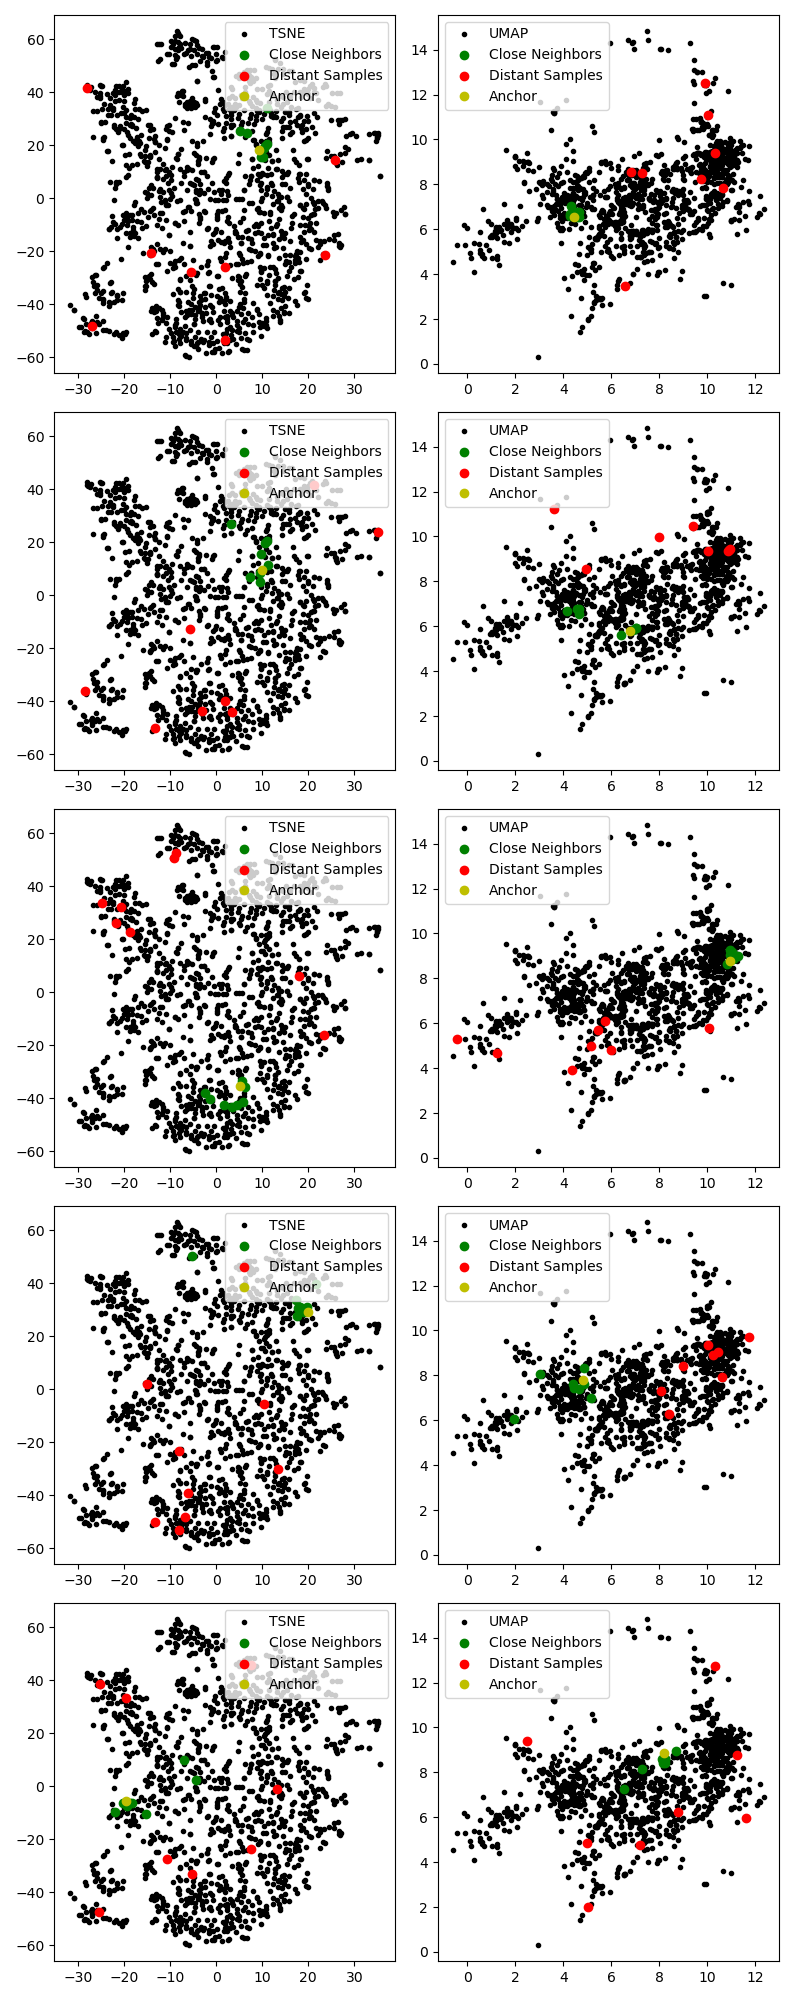

In [33]:
# visualize the sampled points in the TSNE plot
%matplotlib widget

fig, ax = plt.subplots(len(sampled_idx_stack), 2)
fig.set_size_inches(4 * 2, len(sampled_idx_stack) * 4)
for i_row, (s_close, s_distant) in enumerate(sampled_idx_stack):
    anchor_idx = s_close[0]
    ax[i_row, 0].plot (tsne_thinned[:, 0], tsne_thinned[:, 1], 'k.', label='TSNE')
    ax[i_row, 0].plot (tsne_thinned[np.isin(remaining_time_ids, s_close[1:]), 0], tsne_thinned[np.isin(remaining_time_ids, s_close[1:]), 1], 'go', label='Close Neighbors')
    ax[i_row, 0].plot (tsne_thinned[np.isin(remaining_time_ids, s_distant[1:]), 0], tsne_thinned[np.isin(remaining_time_ids, s_distant[1:]), 1], 'ro', label='Distant Samples')
    ax[i_row, 0].plot (tsne_thinned[remaining_time_ids == anchor_idx, 0], tsne_thinned[remaining_time_ids == anchor_idx, 1], 'yo', label='Anchor')
    
    ax[i_row, 1].plot (umap_vectors[:, 0], umap_vectors[:, 1], 'k.', label='UMAP')
    ax[i_row, 1].plot (umap_vectors[np.isin(remaining_time_ids, s_close[1:]), 0], umap_vectors[np.isin(remaining_time_ids, s_close[1:]), 1], 'go', label='Close Neighbors')
    ax[i_row, 1].plot (umap_vectors[np.isin(remaining_time_ids, s_distant[1:]), 0], umap_vectors[np.isin(remaining_time_ids, s_distant[1:]), 1], 'ro', label='Distant Samples')
    ax[i_row, 1].plot (umap_vectors[remaining_time_ids == anchor_idx, 0], umap_vectors[remaining_time_ids == anchor_idx, 1], 'yo', label='Anchor')
    
    ax[i_row, 0].legend()
    ax[i_row, 1].legend()
    
plt.tight_layout()


Observation: after running the code multiple times with different anchors, the close neighbors in the latent space tend to be also closer than the distant neighbors in the t-SNE/UMAP projection. However, quite often the anchor and its close neighbors are not concentrated at one point in the projections.

## 4)  Cluster the diluted dataset
Test different clustering approaches and visualize samples from the clusters for visual inspection.

### 4.1) Fuzzy C-Means Clustering

In [15]:
n_clusters_fcm = 10
fcm = FCM(n_clusters=n_clusters_fcm, m=1.1)

fcm.fit(remaining_embeddings)

# output
fcm_centers = fcm.centers
# output is [N,K]: N number of latent embeddings and K the number of clusters; for where each entry is a membership score between 0...1
fcm_labels_soft = fcm.soft_predict(remaining_embeddings)

Explore the fuzzy clusters that where found in the high dim latent space by plotting for each sample its membership encoded as alpha (transparency) in the UMAP projection.

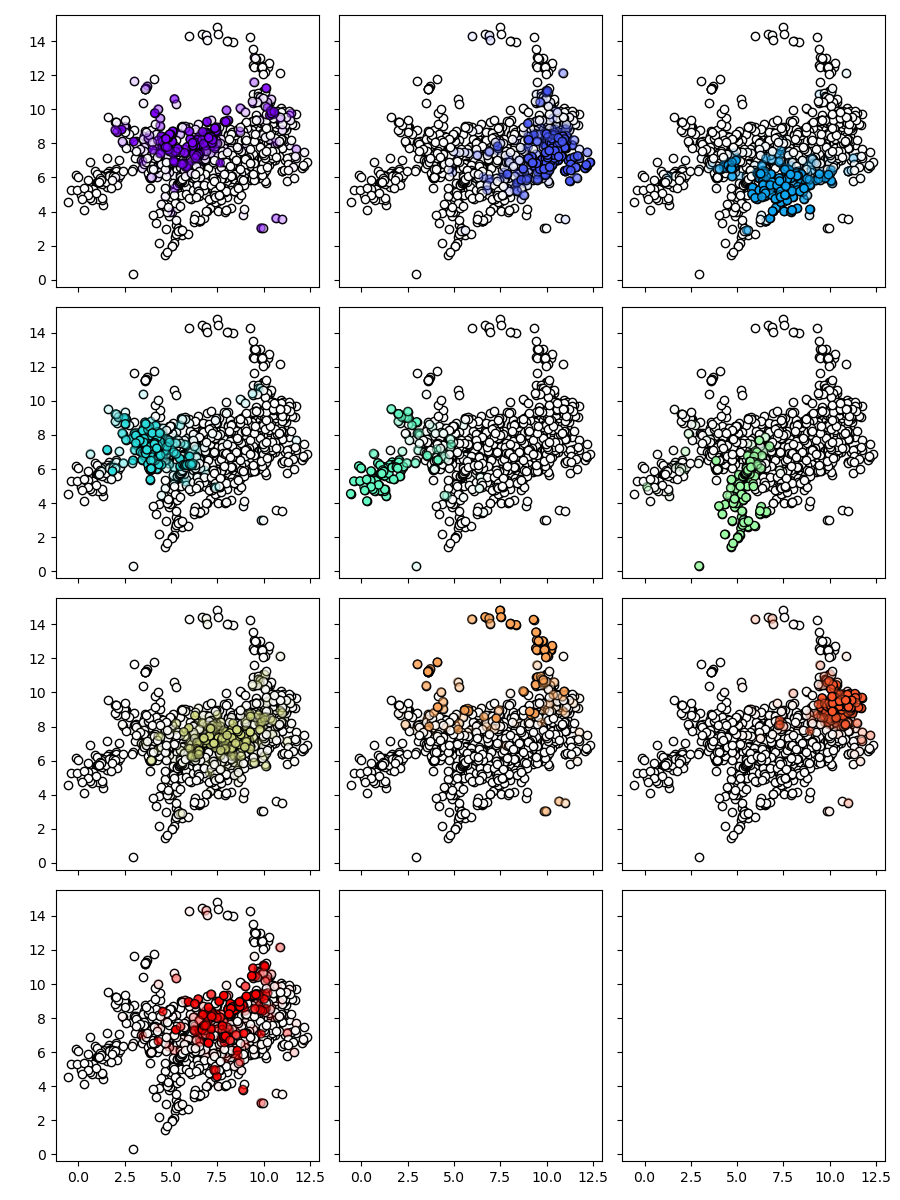

In [34]:
%matplotlib widget
n_cols = int(n_clusters_fcm**0.5)
n_rows = int(np.ceil(n_clusters_fcm / n_cols))


fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
fig.set_size_inches(3 * n_cols, 3 * n_rows)
cmap = cm.get_cmap("rainbow", n_clusters_fcm)
for i_cluster in range(n_clusters_fcm):
    i_col = i_cluster % n_cols
    i_row = i_cluster // n_cols
    ax[i_row][i_col].scatter(umap_vectors[:,0], umap_vectors[:,1],color="w", edgecolor="k")
    ax[i_row][i_col].scatter(umap_vectors[:,0], umap_vectors[:,1],color=cmap(i_cluster), alpha=list(fcm_labels_soft[:,i_cluster]), edgecolor="k")

plt.tight_layout()


Observation: the found clusters in the high dim space are also close in the UMAP projection.

### How many samples have a cluster membership score of at least thr?
The fuzzy c-means algorithm will predict for each sample its membership to all of the K clusters. The membership is a score between 0 and 1 which is NOT a probability therefore the membership scores of a sample can not sum up to one.
To investigate how high the membership scores are plot a histogramm based on the largest membership score of each sample.

88.81% of the samples have a largest cluster membership score above 0.6.


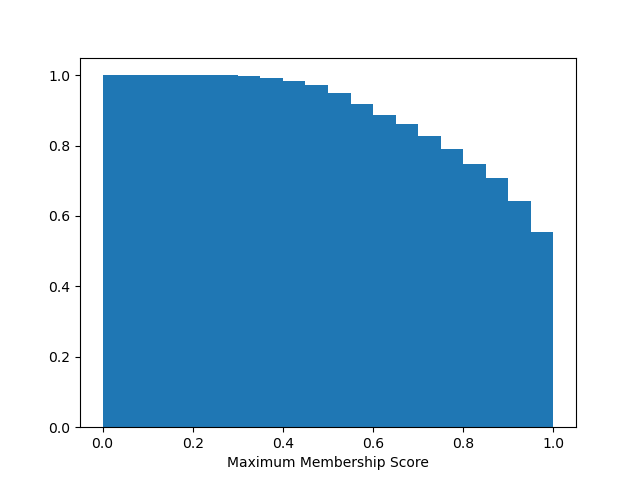

In [17]:
# histogramm of the largest cluster assignment score per sample
%matplotlib widget
cluster_membership_thr = 0.6

fcm_max_val = np.max(fcm_labels_soft, axis=1)
plt.hist(fcm_max_val, bins=20, range=(0,1), density=True, cumulative=-1)
plt.xlabel("Maximum Membership Score")
thr_fraction = round(sum(fcm_max_val > cluster_membership_thr) / len(fcm_max_val) * 100, 2)
print(f"{thr_fraction}% of the samples have a largest cluster membership score above {cluster_membership_thr}.")

Investigate how the found clusters of the fuzzy c-means clustering a projected in the t-SNE/UMAP embedding. Therefore assign each sample to the cluster with its highest membership score and mark samples that are below a minim membership score as outliers.

In [18]:
# predict label from soft labels and set for samples with max value < cluster_membership_thr to -1
fcm_labels = np.ones(fcm_labels_soft.shape[0]) * -1
fcm_labels[np.max(fcm_labels_soft, axis=1) > cluster_membership_thr] = np.argmax(fcm_labels_soft, axis=1)[np.max(fcm_labels_soft, axis=1) > cluster_membership_thr]


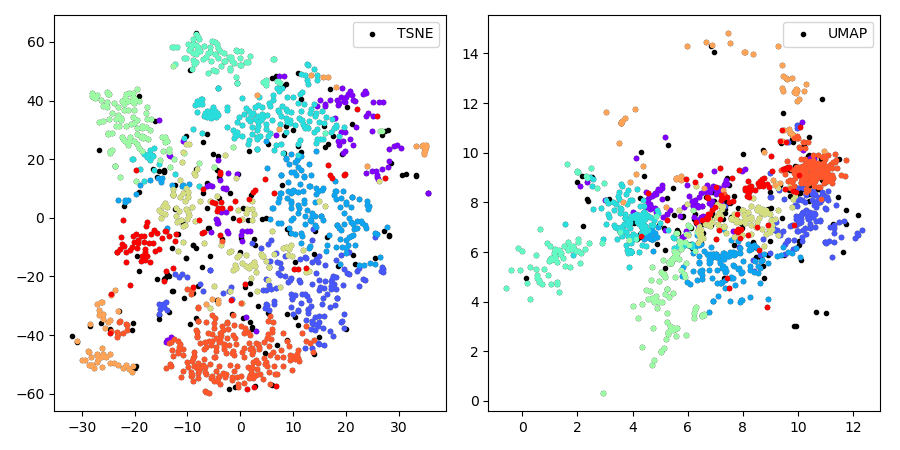

In [43]:
# overlay found clusters with t-SNE / UMAP Projection
%matplotlib widget

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(4.5 * 2, 4.5)

ax[0].plot(tsne_thinned[:, 0], tsne_thinned[:, 1], 'k.', label='TSNE')
ax[1].plot(umap_vectors[:, 0], umap_vectors[:, 1], "k.", label=f'UMAP')
ax[0].legend()
ax[1].legend()
cmap = cm.get_cmap("rainbow", n_clusters_fcm)
for i_cluster in range(n_clusters_fcm):
    anchor_idx = s_close[0]
    ax[0].plot(tsne_thinned[fcm_labels==i_cluster, 0], tsne_thinned[fcm_labels==i_cluster, 1],".", color=cmap(i_cluster), label=f'Cluster: {i_cluster}')
    ax[1].plot(umap_vectors[fcm_labels==i_cluster, 0], umap_vectors[fcm_labels==i_cluster, 1],".", color=cmap(i_cluster), label=f'Cluster: {i_cluster}')

        

    
plt.tight_layout()

Observation: Some clusters found by the fuzzy-c-means clustering that was performed on the highdim latent space tend to also to be placed close in the t-SNE/UMAP projections.

### Sample from the found clusters and show the corresponding time series
Examine the quality found clusters of the diluted latent space by sampling latent vectors assigned to the same cluster and plotting their corresponding time series.

In [37]:
# Select a cluster, sample from it and visualize
# select only the points with a high assignment score to sample from
cluster_id = 0

# all selected time points including anchor and its nearest neighbors
time_ids_cluster = np.random.choice(remaining_time_ids[fcm_labels == cluster_id], 16, replace=False)

video_clip_data_cluster = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in time_ids_cluster]
grid_video_cluster = create_grid_video(video_clip_data_cluster,video_clip_duration,speed=0.5,nrows=4,ncols=4) # duration is in seconds!!

# print Euclidean distances between the samples from the cluster
dist_matrix_cluster = np.round(squareform(pdist(latent_vectors_all[time_ids_cluster])), 2)
#print(f"Distances latent embeddings:\n {dist_matrix_cluster}")

display.Video(grid_video_cluster, embed=True,html_attributes="loop autoplay", width=600,height=600)

INFO: 2022-05-26 14:08:49,382: Scene 0 done (100%).
INFO: 2022-05-26 14:08:49,382: Concatenating 1 scenes.


In [21]:
### 4.2) FlAME Clustering

In [38]:
import sys
sys.path.append("/home/katharina/flame-clustering/")
from pyflame import flame_clustering
flame_labels_soft = flame_clustering(remaining_embeddings, fuzzy_clusters=True, knn=20, epsilon=1e-1, min_membership_thr=0.1)
n_clusters_flame = flame_labels_soft.shape[-1]
flame_labels = np.argmax(flame_labels_soft,axis=1)

done
Set data matrix...done 
Detecting Cluster Supporting Objects ...done, found 10
Propagating fuzzy memberships ... 

1.6% of the samples have a largest cluster membership score above 0.6.


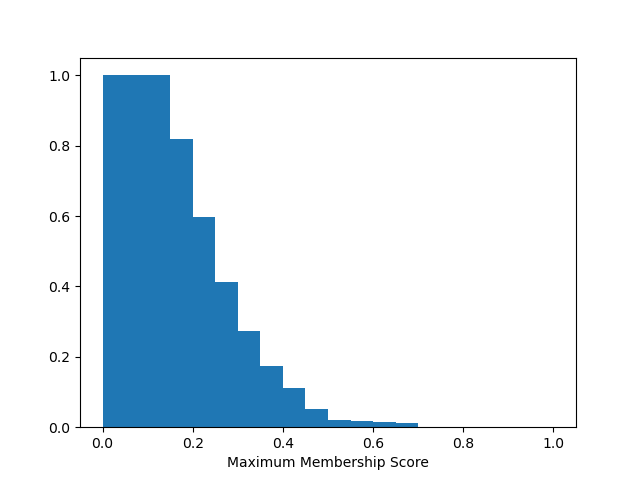

In [39]:
%matplotlib widget
plt.hist(np.max(flame_labels_soft, axis=1) , bins=20, range=(0,1), density=True, cumulative=-1)
plt.xlabel("Maximum Membership Score")
thr_fraction = round(sum(np.max(flame_labels_soft, axis=1)  > cluster_membership_thr) / flame_labels_soft.shape[0] * 100, 2)
print(f"{thr_fraction}% of the samples have a largest cluster membership score above {cluster_membership_thr}.")

In [40]:
cluster_membership_thr_flame = 0.2
flame_labels[np.max(flame_labels_soft, axis=1) < cluster_membership_thr_flame] = -1 


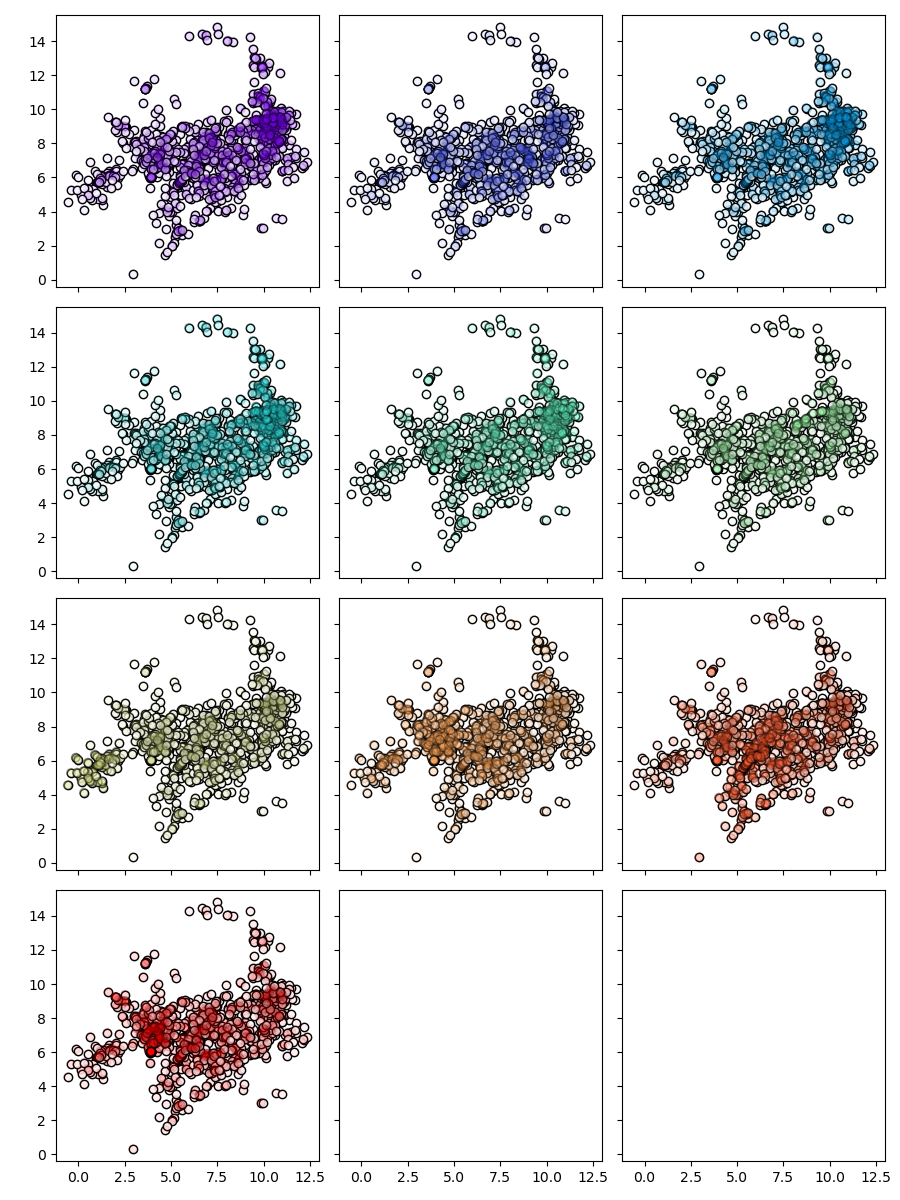

In [41]:
%matplotlib widget
n_cols = int(n_clusters_flame**0.5)
n_rows = int(np.ceil(n_clusters_flame / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
fig.set_size_inches(3 * n_cols, 3 * n_rows)
cmap = cm.get_cmap("rainbow", n_clusters_flame)
for i_cluster in range(n_clusters_flame):
    i_col = i_cluster % n_cols
    i_row = i_cluster // n_cols
    ax[i_row][i_col].scatter(umap_vectors[:,0], umap_vectors[:,1],color="w", edgecolor="k")
    ax[i_row][i_col].scatter(umap_vectors[:,0], umap_vectors[:,1],color=cmap(i_cluster), alpha=list(flame_labels_soft[:,i_cluster]), edgecolor="k")

plt.tight_layout()

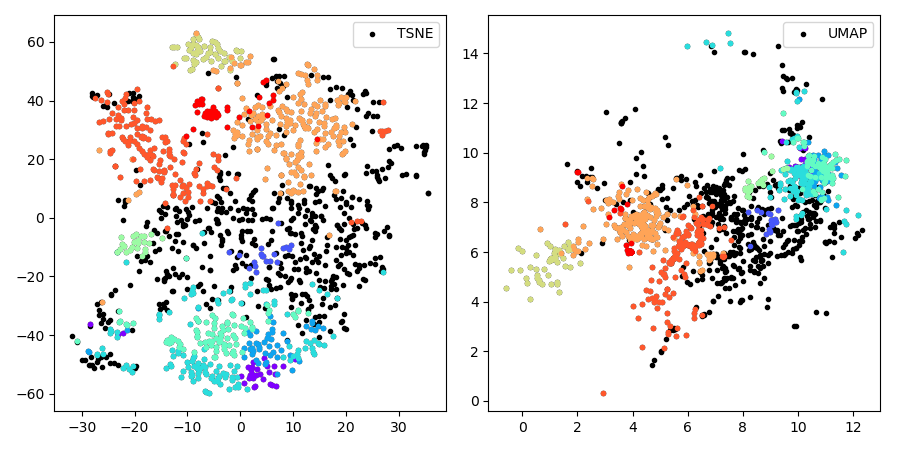

In [42]:
%matplotlib widget

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(4.5 * 2, 4.5)

ax[0].plot(tsne_thinned[:, 0], tsne_thinned[:, 1], 'k.', label='TSNE')
ax[1].plot(umap_vectors[:, 0], umap_vectors[:, 1], "k.", label=f'UMAP')
ax[0].legend()
ax[1].legend()
cmap = cm.get_cmap("rainbow", n_clusters_flame)
for i_cluster in range(n_clusters_flame):
    ax[0].plot(tsne_thinned[flame_labels==i_cluster, 0], tsne_thinned[flame_labels==i_cluster, 1],".", color=cmap(i_cluster), label=f'Cluster: {i_cluster}')
    ax[1].plot(umap_vectors[flame_labels==i_cluster, 0], umap_vectors[flame_labels==i_cluster, 1],".", color=cmap(i_cluster), label=f'Cluster: {i_cluster}')
plt.tight_layout()

### Sample from the found clusters and show the corresponding time series
Examine the quality found clusters of the diluted latent space by sampling latent vectors assigned to the same cluster and plotting their corresponding time series.

In [45]:
# Select a cluster, sample from it and visualize
# select only the points with a high assignment score to sample from
cluster_id = 6

# all selected time points including anchor and its nearest neighbors
time_ids_cluster = np.random.choice(remaining_time_ids[flame_labels == cluster_id], 16, replace=False)

video_clip_data_cluster = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in time_ids_cluster]
grid_video_cluster = create_grid_video(video_clip_data_cluster,video_clip_duration,speed=0.5,nrows=4,ncols=4) # duration is in seconds!!

# print Euclidean distances between the samples from the cluster
dist_matrix_cluster = np.round(squareform(pdist(latent_vectors_all[time_ids_cluster])), 2)
#print(f"Distances latent embeddings:\n {dist_matrix_cluster}")

display.Video(grid_video_cluster, embed=True,html_attributes="loop autoplay", width=600,height=600)

INFO: 2022-05-26 14:16:12,478: Scene 0 done (100%).
INFO: 2022-05-26 14:16:12,478: Concatenating 1 scenes.


In [46]:
### Do PCA and show highdim clusters / show

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_vectors = pca.fit_transform(remaining_embeddings)


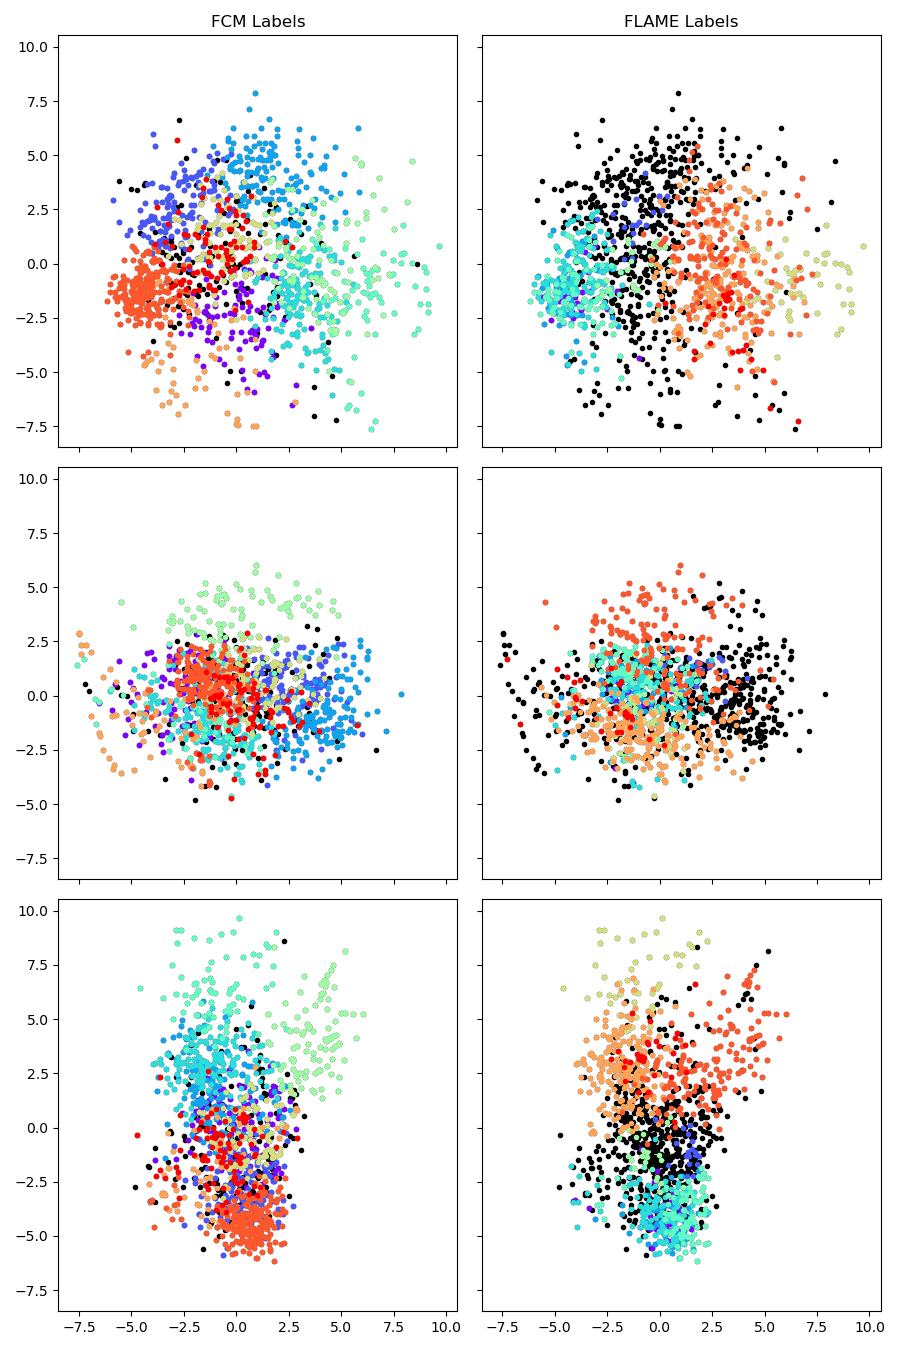

In [47]:
%matplotlib widget
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(4.5 * 2, 4.5 * 3)

for i_dim in range(3):
    ax[i_dim][0].plot(pca_vectors[:, i_dim], pca_vectors[:, (i_dim+1)%3], "k.", label="PCA")
    ax[i_dim][1].plot(pca_vectors[:, i_dim], pca_vectors[:,  (i_dim+1)%3], "k.", label="PCA")

cmap = cm.get_cmap("rainbow", n_clusters_fcm)
ax[0][0].set_title("FCM Labels")
for i_cluster in range(n_clusters_fcm):
    for i_dim in range(3):
        ax[i_dim][0].plot(pca_vectors[fcm_labels==i_cluster, i_dim], pca_vectors[fcm_labels==i_cluster,  (i_dim+1)%3],".", color=cmap(i_cluster), label=f'Cluster: {i_cluster}')

    
ax[0][1].set_title("FLAME Labels")
for i_cluster in range(n_clusters_flame):
    for i_dim in range(3):
        ax[i_dim][1].plot(pca_vectors[flame_labels==i_cluster, i_dim], pca_vectors[flame_labels==i_cluster,  (i_dim+1)%3],".", color=cmap(i_cluster), label=f'Cluster: {i_cluster}')
    
    plt.tight_layout()

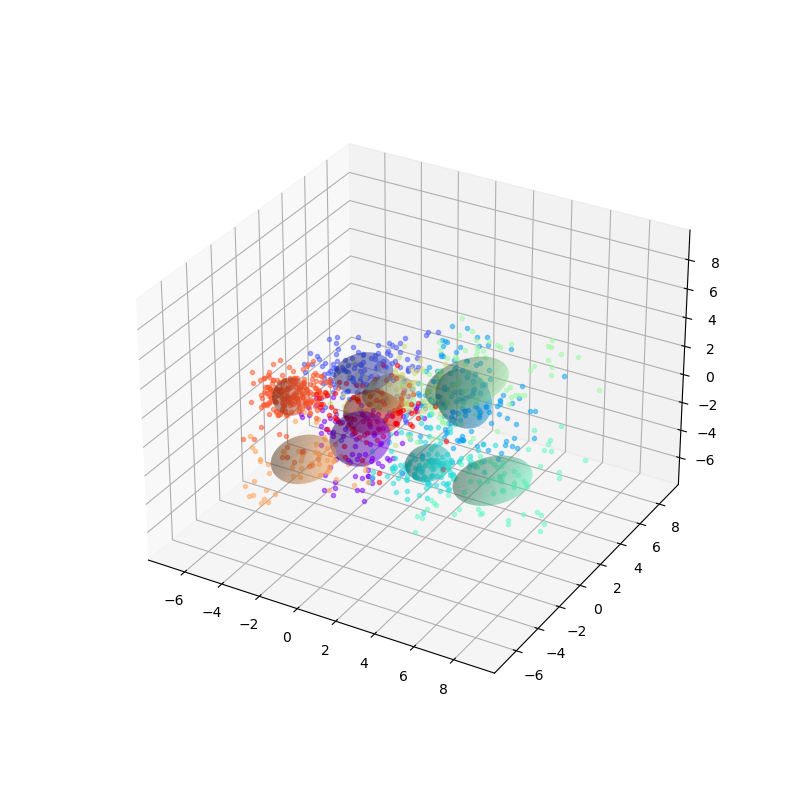

In [48]:
%matplotlib widget

from numpy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors



fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


#set colour map so each ellipsoid as a unique colour
norm = colors.Normalize(vmin=0, vmax=n_clusters_fcm)
cmap = cm.get_cmap("rainbow", n_clusters_fcm)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cluster_means_fcm = [np.mean(pca_vectors[fcm_labels==i_cluster], axis=0) for i_cluster in range(n_clusters_fcm)]
cluster_cov_fcm =  [np.cov(pca_vectors[fcm_labels==i_cluster].T) for i_cluster in range(n_clusters_fcm)]

for i_cluster in range(n_clusters_fcm):
    # your ellispsoid and center in matrix form
    
    center = cluster_means_fcm[i_cluster]
    A = cluster_cov_fcm[i_cluster]
  #TODO: calc eigenvalues and the rotation / and radius of the ellipsoid!
    eigen_vals, eigen_vec = linalg.eig(A)
    radii = np.sqrt(eigen_vals)

    # calculate cartesian coordinates for the ellipsoid surface
    u = np.linspace(0.0, 2.0 * np.pi, 60)
    v = np.linspace(0.0, np.pi, 60)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot(eigen_vec, [x[i,j],y[i,j],z[i,j]]) + center
    ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(i_cluster), linewidth=0.1, alpha=0.3, shade=True)
    ax.plot(pca_vectors[fcm_labels==i_cluster,0],pca_vectors[fcm_labels==i_cluster,1],pca_vectors[fcm_labels==i_cluster,2],".",
           color=m.to_rgba(i_cluster),alpha=0.5)
    
min_val = np.amin(pca_vectors)  # lowest number in the array
max_val = np.amax(pca_vectors)  # highest number in the array

ax.set_xlim3d(min_val, max_val)
ax.set_ylim3d(min_val, max_val)
ax.set_zlim3d(min_val, max_val)
plt.show()


## 5) Cross check found clusters with latent embeddings of another video sequence

predict latent embeddings for another time series, that wasn't used for training the model to investigate whether the found latent space generalizes.

In [49]:
# sanity check - load 0057 and check that the clusters are the same
inference_path = "/home/katharina/vame_approach/themis_tail_belly_align/inference/results/05-12-2022-15-48"
other_latent_vec_file = "latent_vectors_dmarks_0057_3843S2B10Gaussians_E149.npy"
other_latent_vectors = np.load(os.path.join(inference_path, other_latent_vec_file))

In [50]:
diffs = np.diff(latent_vectors_all - other_latent_vectors)

In [52]:
print(latent_vectors_all.shape, other_latent_vectors.shape)

(72356, 30) (72356, 30)
